# ***Basics Implementation of the Long-Term-Memory in ChatBot***

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore

## Define the in memory store using build in class `InMemoryStore`

In [2]:
in_memory_store = InMemoryStore()

When storing objects (e.g., memories) in the [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore), we provide:

- The `namespace` for the object, a tuple (similar to directories)
- the object `key` (similar to filenames)
- the object `value` (similar to file contents)

We use the [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) method to save an object to the store by `namespace` and `key`.

![langgraph_store.png](inmemory.png)

In [3]:
## Namespace for the memory
user_id = "1"
namespace_for_memory = (user_id, "memory")

# save a memory to namespace as key and values
key = str(uuid.uuid4())

# this is the memory context like value of the memory
value = {
    'food_preference': "I like beef"
}

## now save this info into the memory
in_memory_store.put(namespace=namespace_for_memory, key=key, value=value)

#### we use `search` to retrieve the object from the store by namespace
- This is return a list

In [4]:
# search
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [5]:
## Metadata
memories[0].dict()

{'namespace': ['1', 'memory'],
 'key': '132405f5-c8a3-47b5-a913-cb022f8f0e36',
 'value': {'food_preference': 'I like beef'},
 'created_at': '2025-05-12T06:38:58.352749+00:00',
 'updated_at': '2025-05-12T06:38:58.352749+00:00',
 'score': None}

In [6]:
print(memories[0].key, memories[0].value)

132405f5-c8a3-47b5-a913-cb022f8f0e36 {'food_preference': 'I like beef'}


We can also use [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get) to retrieve an object by `namespace` and `key`.

In [7]:
## get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()


{'namespace': ['1', 'memory'],
 'key': '132405f5-c8a3-47b5-a913-cb022f8f0e36',
 'value': {'food_preference': 'I like beef'},
 'created_at': '2025-05-12T06:38:58.352749+00:00',
 'updated_at': '2025-05-12T06:38:58.352749+00:00'}

In [8]:
memory_content = memory.value.get("food_preference")
memory_content

'I like beef'

# ***Time to Build Chatbot with long-term-memory***

In [9]:
from IPython.display import display, Image
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
load_dotenv()
import os

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

groq_api_key = os.getenv("GROQ_API_KEY")

model = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

## Necessary Prompt

In [10]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

## **Call model**

In [11]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load memory from the store and use it to personalize the chatbot's response"""
    
    ## get the user id
    user_id = config['configurable']['user_id']
    
    ## retriever memory form the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace=namespace, key=key)
    
    ## extract the existing memory and add as the prefix
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "No existing memory found."
        
    ## format the memory to the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    ## respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
    
    return {
        'messages': response
    }
    
    
## Write the memory
    
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Reflect on the chat history and save a memory to the store"""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    
    # format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory = existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
    
    ## overwrite the existing memory in the store
    key = "user_memory"
    
    ## write the value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})
        

## Define the graph

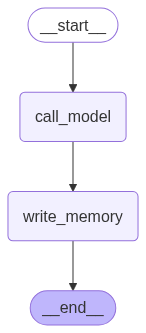

In [12]:
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, 'call_model')
builder.add_edge('call_model', 'write_memory')
builder.add_edge("write_memory", END)

## store for long-term memory(across thread) memory
across_thread_memory = InMemoryStore()

## checkpointer for short-term (within thread) memory
within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

## display the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

When we interact with the chatbot, we supply two things:

1. `Short-term (within-thread) memory`: A `thread ID` for persisting the chat history.
2. `Long-term (cross-thread) memory`: A `user ID` to namespace long-term memories to the user.

Let's see how these work. 

In [13]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Assalamualikum, my name is AlAmin")]

## run the graph with streaming mode
for chunk in graph.stream(
    {
        "messages": input_messages
    },
    config=config,
    stream_mode='values'
):
    chunk['messages'][-1].pretty_print()



================================ Human Message =================================

Assalamualikum, my name is AlAmin
================================== Ai Message ==================================

Wa alaikumussalam, AlAmin! It's nice to meet you. How are you today?


In [14]:
# User input 
input_messages = [HumanMessage(content="Allhamdulliha, I like to bike around Bashundhra-r/a, Dhaka")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Allhamdulliha, I like to bike around Bashundhra-r/a, Dhaka
================================== Ai Message ==================================

Alhamdulillah! Bashundhara Residential Area in Dhaka is a lovely place to bike around. The roads are relatively smooth, and it's a great way to stay active and enjoy the outdoors. Do you have a favorite route or spot in Bashundhara that you like to visit while biking?


We're using the `MemorySaver` checkpointer for within-thread memory.

This saves the chat history to the thread.

We can look at the chat history saved to the thread.

In [15]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Assalamualikum, my name is AlAmin
================================== Ai Message ==================================

Wa alaikumussalam, AlAmin! It's nice to meet you. How are you today?
================================ Human Message =================================

Allhamdulliha, I like to bike around Bashundhra-r/a, Dhaka
================================== Ai Message ==================================

Alhamdulillah! Bashundhara Residential Area in Dhaka is a lovely place to bike around. The roads are relatively smooth, and it's a great way to stay active and enjoy the outdoors. Do you have a favorite route or spot in Bashundhara that you like to visit while biking?


Recall that we compiled the graph with our the store: 

```python
across_thread_memory = InMemoryStore()
```

And, we added a node to the graph (`write_memory`) that reflects on the chat history and saves a memory to the store.

We can to see if the memory was saved to the store.

In [16]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': ' \n\n**Current User Information:**\n* Name: AlAmin\n* Location: Bashundhara Residential Area, Dhaka\n* Interests/Hobbies: Biking'},
 'created_at': '2025-05-12T06:39:02.331949+00:00',
 'updated_at': '2025-05-12T06:39:02.331949+00:00'}

Now, let's kick off a *new thread* with the *same user ID*.

We should see that the chatbot remembered the user's profile and used it to personalize the response.

In [17]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Assalamualikum! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Assalamualikum! Where would you recommend that I go biking?
================================== Ai Message ==================================

Wa alaikumussalam! Ah, biking is a great hobby, AlAmin! I'm glad you asked.

Considering you're from Bashundhara Residential Area, Dhaka, I'd recommend the following biking spots:

1. **Hatirjheel Lake**: A scenic and relatively flat route with a dedicated bike lane. You can enjoy the lake's views and the city's vibrant atmosphere.
2. **Banani Lake**: Another beautiful spot with a walking and biking path. The lake's surroundings are perfect for a leisurely bike ride.
3. **Gulshan Lake Park**: A peaceful spot with a designated bike path. You can enjoy the serene environment and some exercise.
4. **The Liberation War Museum to Suhrawardy Uddan route**: A relatively flat and scenic route that takes you through some of Dhaka's historic areas.

If you're looking for a mo